In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
import seaborn as sns


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-06-06 10:28:49.282529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Helper function to preprocess images
def preprocess(images, labels):
  return tf.keras.applications.inception_v3.preprocess_input(images), labels

## View model structure

In [11]:
model = InceptionV3()

In [13]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

## Load data

In [8]:
train_csv = pd.read_csv("chexpert/train.csv")
valid_csv = pd.read_csv("chexpert/valid.csv")
# Choose only frontal images
train_csv = train_csv[train_csv["Frontal/Lateral"] == "Frontal"]
valid_csv = valid_csv[valid_csv["Frontal/Lateral"] == "Frontal"]

# Change image path
train_csv["Path"] = train_csv["Path"].str.replace("CheXpert-v1.0-small/train", "chexpert/train-kopi")
valid_csv["Path"] = valid_csv["Path"].str.replace("CheXpert-v1.0-small/train", "chexpert/train-kopi")


In [18]:
train_csv.columns

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

In [17]:
pathology_counts

{'No Finding': 16974,
 'Enlarged Cardiomediastinum': 9187,
 'Cardiomegaly': 23385,
 'Lung Opacity': 94211,
 'Lung Lesion': 7040,
 'Edema': 49675,
 'Consolidation': 12983,
 'Pneumonia': 4675,
 'Atelectasis': 29720,
 'Pneumothorax': 17693,
 'Pleural Effusion': 76899,
 'Pleural Other': 2505,
 'Fracture': 7436,
 'Support Devices': 107170}

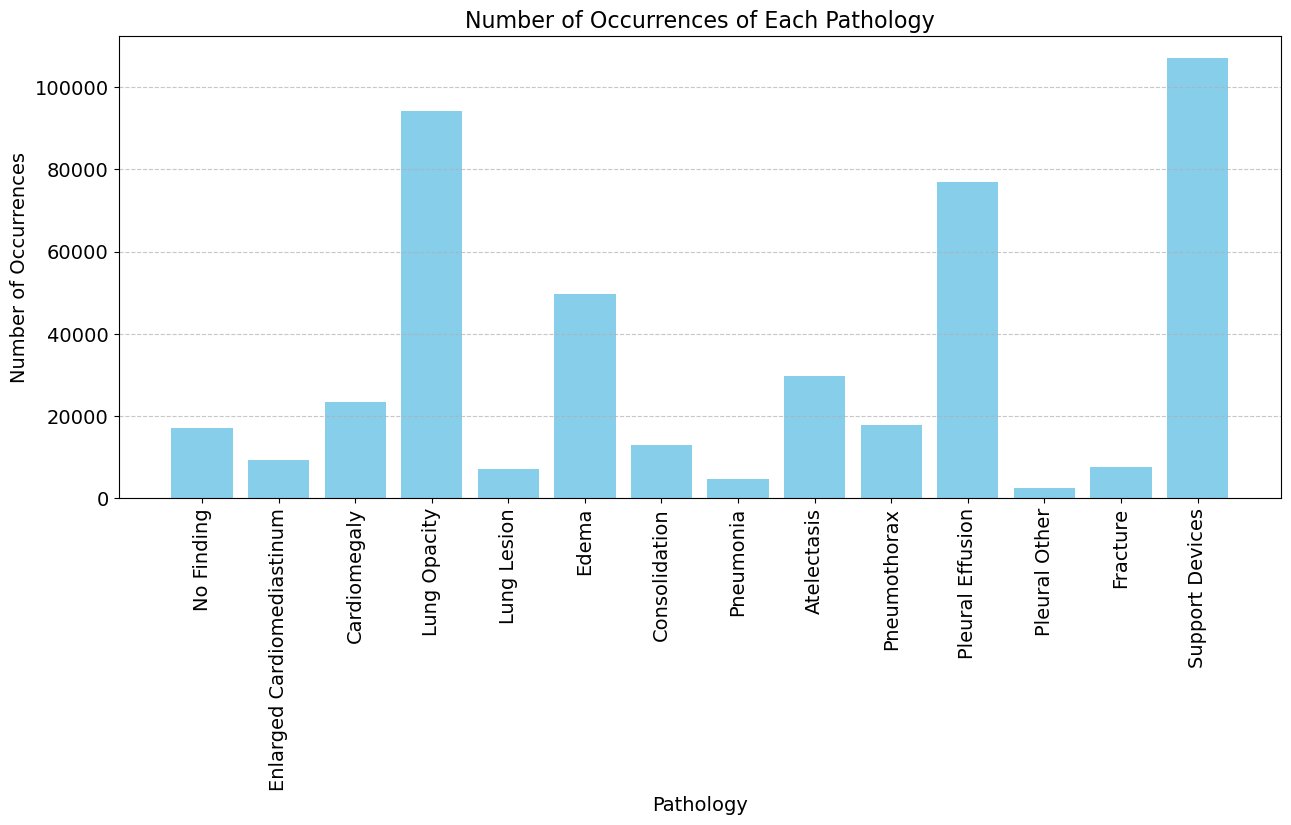

In [16]:
train_csv = pd.read_csv("chexpert/train.csv")
train_csv = train_csv[train_csv["Frontal/Lateral"] == "Frontal"]
df = train_csv

# Drop non-essential columns
df.drop(columns=['Path', 'Sex', 'Age', 'Frontal/Lateral','AP/PA'], inplace=True)

# Calculate the sum of each pathology column
pathology_counts = {}

for column in df.columns:
    pathology_counts[column] = (df[column] == 1).sum()

# Plot the bar plot
plt.figure(figsize=(15, 6))
plt.bar(pathology_counts.keys(), pathology_counts.values(), color='skyblue')
plt.title('Number of Occurrences of Each Pathology')
plt.xlabel('Pathology')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Statistics of the data

In [13]:
# Find number of unique patients
train_csv = pd.read_csv("chexpert/train.csv")
train_csv = train_csv[train_csv["Frontal/Lateral"] == "Frontal"]
train_csv["Path"] = train_csv["Path"].str.replace("CheXpert-v1.0-small/train", "chexpert/train-kopi")
train_csv['Patient'] = train_csv['Path'].str.extract(r'/(patient\d+)/')

In [7]:
train_csv['Patient'].nunique()

64534

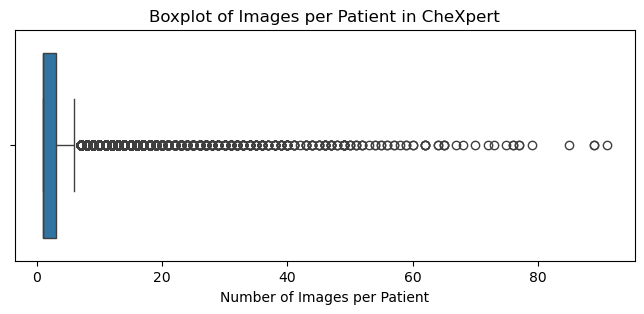

In [19]:
patient_counts = train_csv['Patient'].value_counts().reset_index()
patient_counts.columns = ['Patient', 'ImageCount']

# Plot the boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(x=patient_counts['ImageCount'])
plt.xlabel('Number of Images per Patient')
plt.title('Boxplot of Images per Patient in CheXpert')
plt.show()

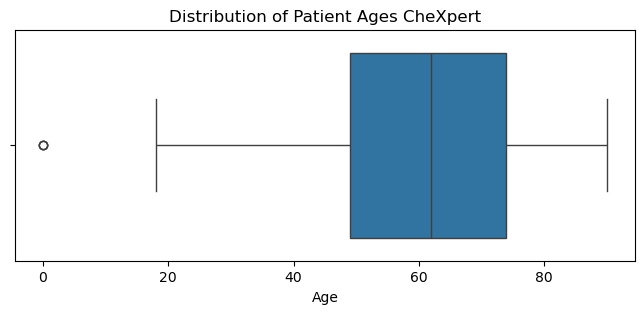

In [23]:
# Plot the boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(x=train_csv['Age'])
plt.xlabel('Age')
plt.title('Distribution of Patient Ages CheXpert')
plt.show()

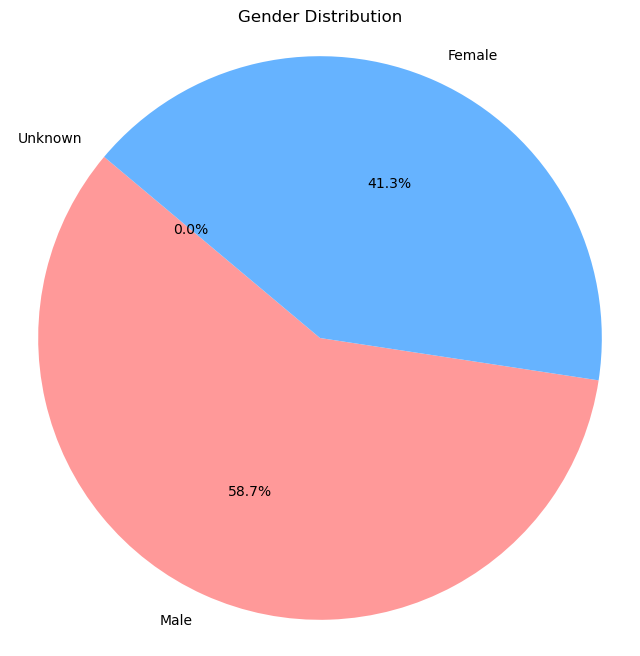

In [25]:
gender_counts = train_csv['Sex'].value_counts()
gender_percentages = gender_counts / gender_counts.sum() * 100

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(gender_percentages, labels=gender_percentages.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Gender Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

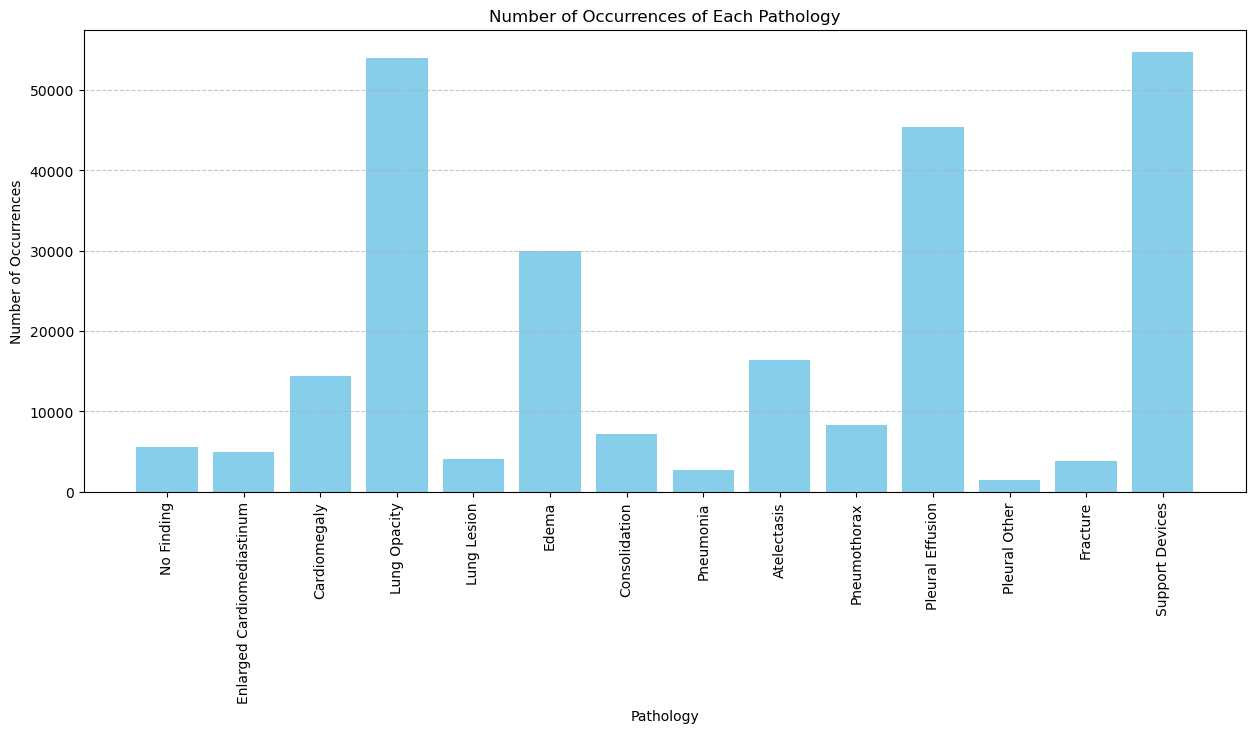

In [30]:
# Diseases for people over 60
train_csv = pd.read_csv("chexpert/train.csv")
train_csv = train_csv[train_csv["Frontal/Lateral"] == "Frontal"]
train_csv = train_csv[train_csv["Age"] > 60]
df = train_csv

# Drop non-essential columns
df.drop(columns=['Path', 'Sex', 'Age', 'Frontal/Lateral','AP/PA'], inplace=True)

# Calculate the sum of each pathology column
pathology_counts = {}

# Loop over each column (excluding 'No Finding')
for column in df.columns:
    # Count occurrences of 1 in the current column
    pathology_counts[column] = (df[column] == 1).sum()

# Plot the bar plot
plt.figure(figsize=(15, 6))
plt.bar(pathology_counts.keys(), pathology_counts.values(), color='skyblue')
plt.title('Number of Occurrences of Each Pathology')
plt.xlabel('Pathology')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

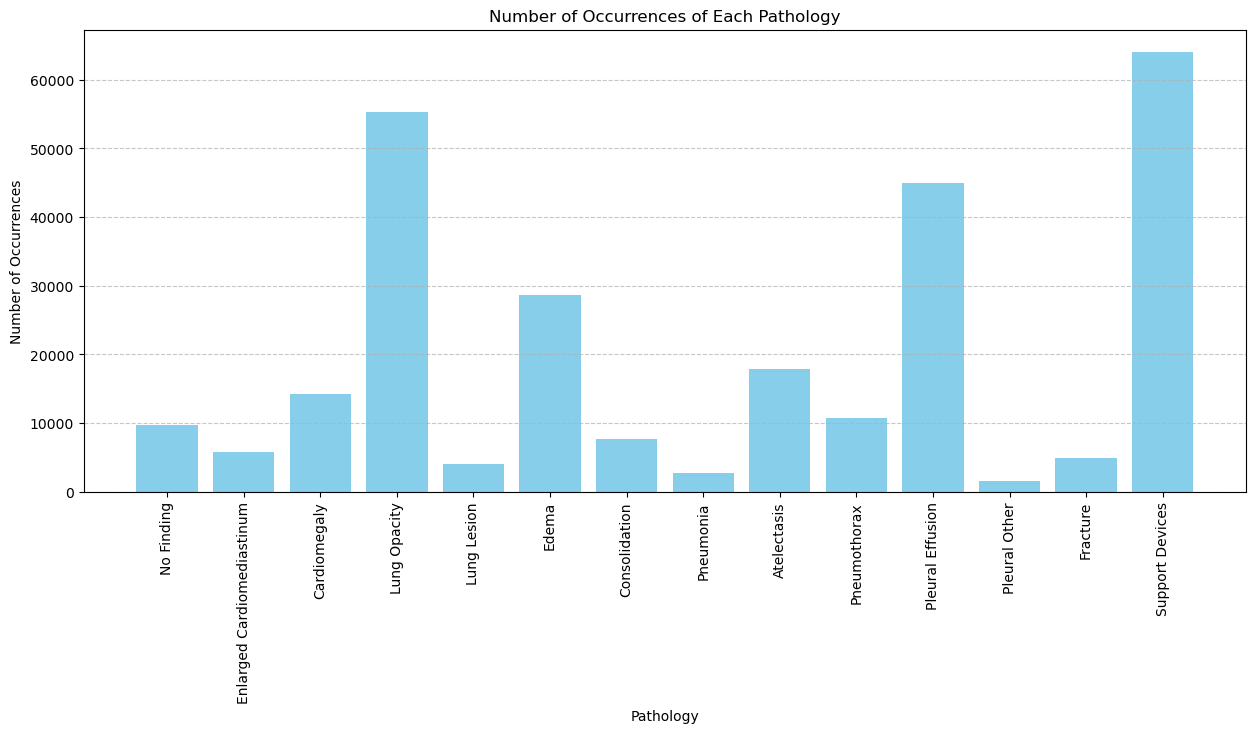

In [31]:
# Diseases for MAles
train_csv = pd.read_csv("chexpert/train.csv")
train_csv = train_csv[train_csv["Frontal/Lateral"] == "Frontal"]
train_csv = train_csv[train_csv["Sex"] == "Male"]
df = train_csv

# Drop non-essential columns
df.drop(columns=['Path', 'Sex', 'Age', 'Frontal/Lateral','AP/PA'], inplace=True)

# Calculate the sum of each pathology column
pathology_counts = {}

# Loop over each column (excluding 'No Finding')
for column in df.columns:
    # Count occurrences of 1 in the current column
    pathology_counts[column] = (df[column] == 1).sum()

# Plot the bar plot
plt.figure(figsize=(15, 6))
plt.bar(pathology_counts.keys(), pathology_counts.values(), color='skyblue')
plt.title('Number of Occurrences of Each Pathology')
plt.xlabel('Pathology')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

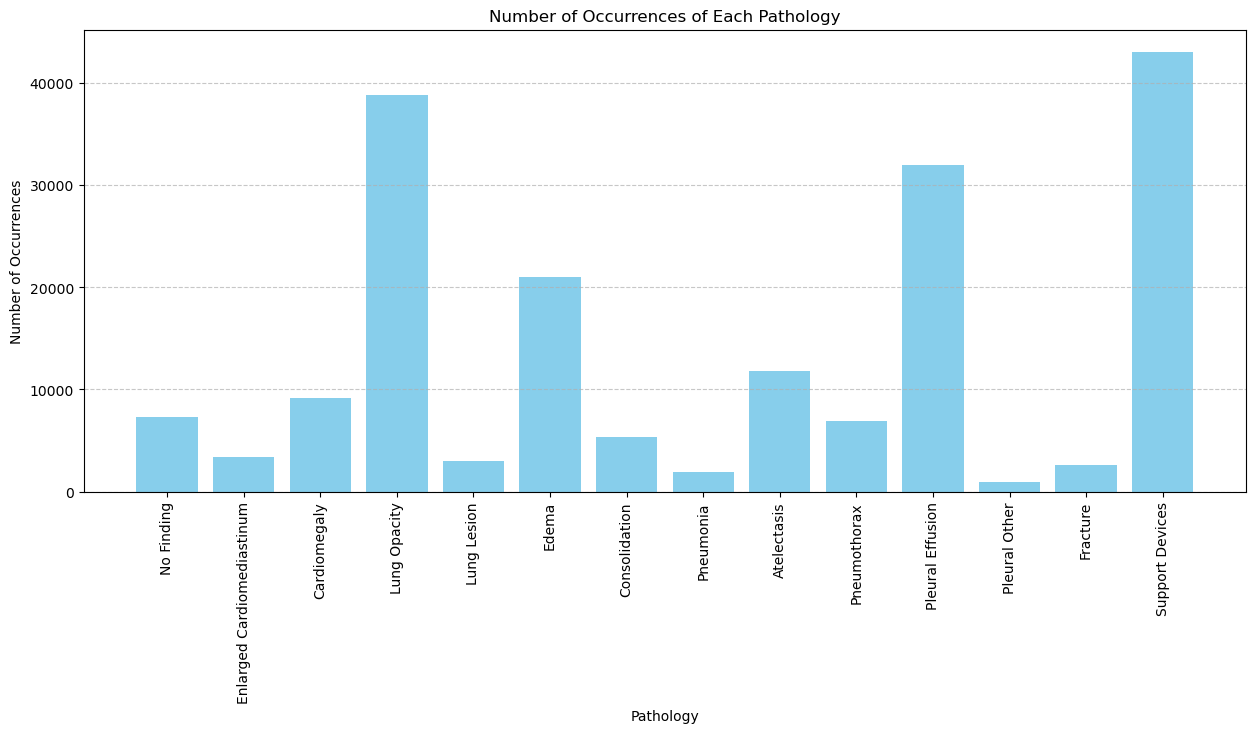

In [32]:
# Diseases for Females
train_csv = pd.read_csv("chexpert/train.csv")
train_csv = train_csv[train_csv["Frontal/Lateral"] == "Frontal"]
train_csv = train_csv[train_csv["Sex"] == "Female"]
df = train_csv

# Drop non-essential columns
df.drop(columns=['Path', 'Sex', 'Age', 'Frontal/Lateral','AP/PA'], inplace=True)

# Calculate the sum of each pathology column
pathology_counts = {}

# Loop over each column (excluding 'No Finding')
for column in df.columns:
    # Count occurrences of 1 in the current column
    pathology_counts[column] = (df[column] == 1).sum()

# Plot the bar plot
plt.figure(figsize=(15, 6))
plt.bar(pathology_counts.keys(), pathology_counts.values(), color='skyblue')
plt.title('Number of Occurrences of Each Pathology')
plt.xlabel('Pathology')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Image load support-device / normal / pneumothorax

In [ ]:
df = train_csv[(train_csv['Support Devices'] == 1)]

# Calculate the sum of each pathology column
pathology_counts = {}

# Loop over each column (excluding 'No Finding')
for column in df.columns:
    # Count occurrences of 1 in the current column
    pathology_counts[column] = (df[column] == 1).sum()

# Plot the bar plot
plt.figure(figsize=(15, 6))
plt.bar(pathology_counts.keys(), pathology_counts.values(), color='skyblue')
plt.title('Number of Occurrences of Each Pathology')
plt.xlabel('Pathology')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
df = train_csv[(train_csv['Pneumothorax'] == 1)]

# Calculate the sum of each pathology column
pathology_counts = {}

# Loop over each column (excluding 'No Finding')
for column in df.columns:
    # Count occurrences of 1 in the current column
    pathology_counts[column] = (df[column] == 1).sum()

# Plot the bar plot
plt.figure(figsize=(15, 6))
plt.bar(pathology_counts.keys(), pathology_counts.values(), color='skyblue')
plt.title('Number of Occurrences of Each Pathology')
plt.xlabel('Pathology')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
normal = train_csv[
    (train_csv['No Finding'] == 1) &
    (train_csv['Support Devices'] != 1)
   ]

device = train_csv[
    (train_csv['No Finding'] == 1) &
    (train_csv['Support Devices'] == 1)
   ]

lung = train_csv[
    (train_csv['Pneumothorax'] == 1) &
    (train_csv['Support Devices'] != 1)
   ]

lung_device = train_csv[
    (train_csv['Pneumothorax'] == 1) &
    (train_csv['Support Devices'] == 1)
   ]

for name in [normal, lung, device, lung_device]:
    print(len(name))

In [ ]:
normal_df = pd.DataFrame(normal["Path"])
normal_df["Label"] = "Normal"
lung_df = pd.DataFrame(lung["Path"])
lung_df["Label"] = "Lung disease"
device_df = pd.DataFrame(device["Path"])
device_df["Label"] = "Support Device"
device_lung_df = pd.DataFrame(lung_device["Path"])
device_lung_df["Label"] = "Support Device and Lung Disease"

train_df = pd.concat([normal_df,lung_df,device_df, device_lung_df])

In [ ]:
normal_count = 1
device_count = 1
lung_count = 1
lung_device_count = 1

for _, row in train_df.iterrows():
  if row['Label'] == "Normal":
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{normal_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/normal", new_filename))
    normal_count += 1
  elif row['Label'] == "Lung disease":
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{lung_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/lung", new_filename))
    lung_count += 1
  elif row['Label'] == "Support Device":
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{device_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/device", new_filename))
    device_count += 1
  elif row['Label'] == "Support Device and Lung Disease":
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{lung_device_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/lung_device", new_filename))
    lung_device_count += 1


######### #####

### Image load Lung/heart / heart / lung

In [ ]:
normal = train_csv[
    (train_csv['No Finding'] == 1)
]

lung = train_csv[
    (train_csv['No Finding'] != 1) &
    (train_csv['Enlarged Cardiomediastinum'] != 1) &
    (train_csv['Cardiomegaly'] != 1) &
    (train_csv['Lung Opacity'] != 1) &
    (train_csv['Lung Lesion'] != 1) &
    (train_csv['Edema'] != 1) &
    (train_csv['Consolidation'] != 1) &
    (train_csv['Pneumonia'] != 1) &
    (train_csv['Atelectasis'] != 1) &
    ((train_csv['Pleural Effusion'] == 1) | (train_csv['Pneumothorax'] == 1) | (train_csv['Pleural Other'] == 1) | (train_csv['Fracture'] == 1))
]

heart = train_csv[
    ((train_csv['Enlarged Cardiomediastinum'] == 1) | (train_csv['Cardiomegaly'] == 1)) &
    (train_csv['Pleural Effusion'] != 1) &
    (train_csv['Pneumothorax'] != 1) &
    (train_csv['Pleural Other'] != 1) &
    (train_csv['Fracture'] != 1) &
    (train_csv['No Finding'] != 1) &
    (train_csv['Lung Opacity'] != 1) &
    (train_csv['Lung Lesion'] != 1) &
    (train_csv['Edema'] != 1) &
    (train_csv['Consolidation'] != 1) &
    (train_csv['Pneumonia'] != 1) &
    (train_csv['Atelectasis'] != 1)
]
# Lung and HEART
heart_lung = train_csv[
    ((train_csv['Enlarged Cardiomediastinum'] == 1) | (train_csv['Cardiomegaly'] == 1)) &
   ((train_csv['Pneumothorax'] == 1) | (train_csv['Pleural Effusion'] == 1) | (train_csv['Pleural Other'] == 1) | (train_csv['Fracture'] == 1) ) &
    (train_csv['No Finding'] != 1) &
    (train_csv['Cardiomegaly'] != 1) &
    (train_csv['Lung Opacity'] != 1) &
    (train_csv['Lung Lesion'] != 1) &
    (train_csv['Edema'] != 1) &
    (train_csv['Consolidation'] != 1) &
    (train_csv['Pneumonia'] != 1) &
    (train_csv['Atelectasis'] != 1)
   ]

for name in [normal, lung, heart, heart_lung]:
    print(len(name))

## Stats

In [ ]:
# Select rows where conditions are met
lung = train_csv[
    (train_csv['No Finding'] != 1) & (train_csv['No Finding'] != -1) &
    (train_csv['Enlarged Cardiomediastinum'] != 1) & (train_csv['Enlarged Cardiomediastinum'] != -1) &
    (train_csv['Cardiomegaly'] != 1) & (train_csv['Cardiomegaly'] != -1) &
    (train_csv['Lung Opacity'] != 1) & (train_csv['Lung Opacity'] != -1) &
    (train_csv['Lung Lesion'] != 1) & (train_csv['Lung Lesion'] != -1) &
    (train_csv['Edema'] != 1) & (train_csv['Edema'] != -1) &
    (train_csv['Consolidation'] != 1) & (train_csv['Consolidation'] != -1) &
    (train_csv['Pneumonia'] != 1) & (train_csv['Pneumonia'] != -1) &
    (train_csv['Atelectasis'] != 1) & (train_csv['Atelectasis'] != -1) &
    ((train_csv['Pleural Effusion'] == 1) | (train_csv['Pneumothorax'] == 1) | (train_csv['Pleural Other'] == 1) | (train_csv['Fracture'] == 1))
]

heart = train_csv[
    ((train_csv['Enlarged Cardiomediastinum'] == 1) | (train_csv['Cardiomegaly'] == 1)) &
    (train_csv['Pleural Effusion'] != 1) & (train_csv['Pleural Effusion'] != -1) &
    (train_csv['Pneumothorax'] != 1) & (train_csv['Pneumothorax'] != -1) &
    (train_csv['Pleural Other'] != 1) & (train_csv['Pleural Other'] != -1) &
    (train_csv['Fracture'] != 1) & (train_csv['Fracture'] != -1) &
    (train_csv['No Finding'] != 1)  &
    (train_csv['Lung Opacity'] != 1)  &
    (train_csv['Lung Lesion'] != 1)  &
    (train_csv['Edema'] != 1)  &
    (train_csv['Consolidation'] != 1)  &
    (train_csv['Pneumonia'] != 1)  &
    (train_csv['Atelectasis'] != 1) 
]

# Lung and HEART
heart_lung = train_csv[
    ((train_csv['Enlarged Cardiomediastinum'] == 1) | (train_csv['Cardiomegaly'] == 1)) &
    ((train_csv['Pneumothorax'] == 1) | (train_csv['Pleural Effusion'] == 1) | (train_csv['Pleural Other'] == 1) | (train_csv['Fracture'] == 1)) &
    (train_csv['No Finding'] != 1) & (train_csv['No Finding'] != -1) &
    (train_csv['Cardiomegaly'] != 1) & (train_csv['Cardiomegaly'] != -1) &
    (train_csv['Lung Opacity'] != 1) & (train_csv['Lung Opacity'] != -1) &
    (train_csv['Lung Lesion'] != 1) & (train_csv['Lung Lesion'] != -1) &
    (train_csv['Edema'] != 1) & (train_csv['Edema'] != -1) &
    (train_csv['Consolidation'] != 1) & (train_csv['Consolidation'] != -1) &
    (train_csv['Pneumonia'] != 1) & (train_csv['Pneumonia'] != -1) &
    (train_csv['Atelectasis'] != 1) & (train_csv['Atelectasis'] != -1)
]

normal = train_csv[
    (train_csv['No Finding'] == 1)
]

# Print the length of each dataset
for name in [normal, lung, heart, heart_lung]:
    print(len(name))


In [ ]:
# Andel uncertainty lung + pleural i heart
1-3715/5072

In [ ]:
# Andel uncertainty pleural i heart
1-4560/5072

In [ ]:
# Andel uncertainty af heart and other lung i pleural diseases
1-12456/16201

## stats slut

In [ ]:
normal_df = pd.DataFrame(normal["Path"])
normal_df["Label"] = "Normal"
lung_df = pd.DataFrame(lung["Path"])
lung_df["Label"] = "Lung disease"
heart_df = pd.DataFrame(heart["Path"])
heart_df["Label"] = "Heart disease"
heart_lung_df = pd.DataFrame(heart_lung["Path"])
heart_lung_df["Label"] = "Lung disease and heart disease"

train_df = pd.concat([normal_df,lung_df,heart_df, heart_lung_df])

In [ ]:
import pandas as pd
import os
import shutil
normal_count = 1
heart_count = 1
lung_count = 1
lung_heart_count = 1

for _, row in train_df.iterrows():
  if row['Label'] == "Normal":
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{normal_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/normal", new_filename))
    normal_count += 1
  elif row['Label'] == "Lung disease":
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{lung_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/lung", new_filename))
    lung_count += 1
  elif row['Label'] == "Heart disease":
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{heart_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/heart", new_filename))
    heart_count += 1
  elif row['Label'] == "Lung disease and heart disease":
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{lung_heart_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/lung_heart", new_filename))
    lung_heart_count += 1


#######

## Gender split

In [ ]:
female = train_csv[
    (train_csv['Sex'] == "Female")
]

male = train_csv[
    (train_csv['Sex'] == "Male")
]

for name in [female, male]:
    print(len(name))

In [ ]:
female_df = pd.DataFrame(female["Path"])
female_df["Label"] = "Female"
male_df = pd.DataFrame(male["Path"])
male_df["Label"] = "Male"

train_df = pd.concat([female_df,male_df])


In [ ]:
train_df

In [ ]:
female_count = 1
male_count = 1

for _, row in train_df.iterrows():
  if (row['Label'] == "Female") & (female_count < 20000):
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{female_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/female", new_filename))
    female_count += 1
  elif (row['Label'] == "Male") & (male_count < 20000):
    f = row['Path']
    basename, extension = os.path.splitext(f)
    new_filename = f"{male_count}_{os.path.basename(basename)}{extension}"
    _ = shutil.move(f, os.path.join("chexpert/train_final/male", new_filename))
    male_count += 1



## Final model

In [ ]:
# Retrieve trained model
loaded_model = tf.keras.saving.load_model("chex_imagenet.keras")

In [ ]:
# Load test images
chexpert_images_raw = tf.keras.utils.image_dataset_from_directory(directory = "nih3/val", image_size= (299, 299),shuffle=True )
chexpert_images = chexpert_images_raw.map(preprocess)

In [ ]:
labels = []
    # Go through each image and extract label
for im, la in chexpert_images:
    labels.append(la.numpy())
labels = np.concatenate(labels)

## Final NIH model evaluation

In [ ]:
import json
# Load the predictions from the file
with open('labels_data_3.json', 'r') as file:
    data = json.load(file)
    pred_labels_list = data['pred_labels']
    labels_list = data['labels']
    predictions_list = data['predictions']

pred_labels = np.array(pred_labels_list)
labels = np.array(labels_list)
predictions = np.array(predictions_list)

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(labels,predictions, plot_chance_level=True, name = "NIH-InceptionV3")

In [ ]:
# Best prediction threshold
pred_labels = ((predictions > 0.40)+0).ravel()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, pred_labels)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(labels, pred_labels, display_labels = ["Disease", "No-disease"])


In [ ]:
# Majority class baseline (Normal is majority)
pred_labels_majority = np.ones(len(labels))
print(accuracy_score(labels, pred_labels_majority))
ConfusionMatrixDisplay.from_predictions(labels, pred_labels_majority, display_labels = ["Disease", "No-disease"] )

In [ ]:
y_pred_random = np.random.choice([0, 1], size=len(pred_labels))
print(accuracy_score(labels, y_pred_random))
ConfusionMatrixDisplay.from_predictions(labels, y_pred_random)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = y_pred_random

accuracy = accuracy_score(labels, y_pred_random)
precision = precision_score(labels, y_pred_random)
recall = recall_score(labels, y_pred_random)
f1 = f1_score(labels, y_pred_random)

print(f"Random baseline accuracy: {accuracy:.2f}")
print(f"Random baseline precision: {precision:.2f}")
print(f"Random baseline recall: {recall:.2f}")
print(f"Random baseline F1 score: {f1:.2f}")

print("                                         ")
accuracy = accuracy_score(labels, pred_labels_majority)
precision = precision_score(labels, pred_labels_majority)
recall = recall_score(labels, pred_labels_majority)
f1 = f1_score(labels, pred_labels_majority)

print(f"Majority baseline accuracy: {accuracy:.2f}")
print(f"Majority baseline precision: {precision:.2f}")
print(f"Majority baseline recall: {recall:.2f}")
print(f"Majority baseline F1 score: {f1:.2f}")

print("                                         ")
accuracy = accuracy_score(labels, pred_labels)
precision = precision_score(labels, pred_labels)
recall = recall_score(labels, pred_labels)
f1 = f1_score(labels, pred_labels)

print(f"Model accuracy: {accuracy:.2f}")
print(f"Model precision: {precision:.2f}")
print(f"Model recall: {recall:.2f}")
print(f"Model F1 score: {f1:.2f}")

## Model training

In [2]:
# Train / Val loss

train_loss = [0.6632, 0.6262, 0.6121, 0.6035, 0.5975, 0.5973, 0.5875, 0.5821, 0.5708] + [0.5607, 0.5445, 0.5200, 0.4821, 0.4372]
val_loss = [0.6507, 0.6358, 0.6184, 0.6223, 0.6167, 0.6200, 0.6153, 0.6107, 0.6094] + [0.6518, 0.6393, 0.6501, 0.6923, 0.7318]


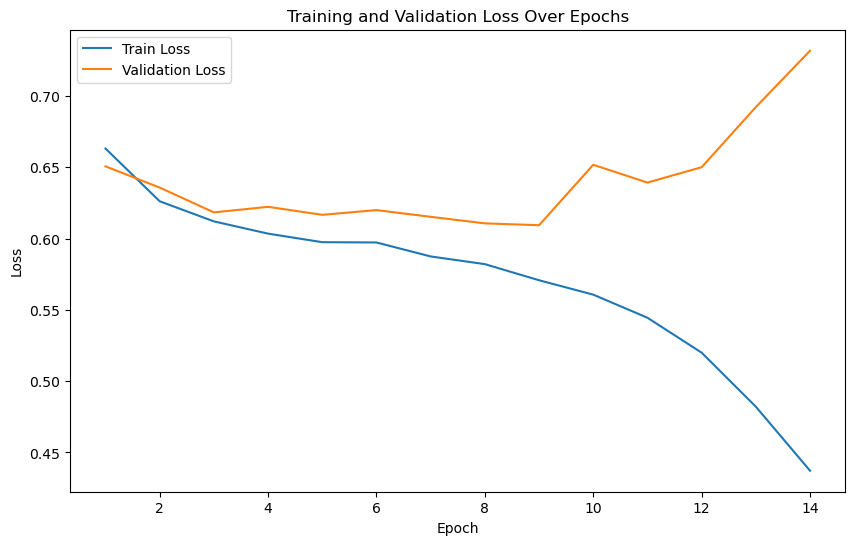

In [4]:
# plot train and validation loss
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(train_loss) + 1, 1), train_loss, label='Train Loss')
plt.plot(np.arange(1, len(val_loss) + 1, 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks()
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.show()


## Relative

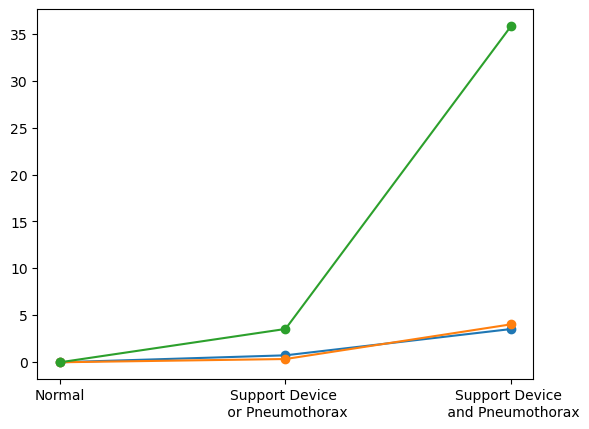

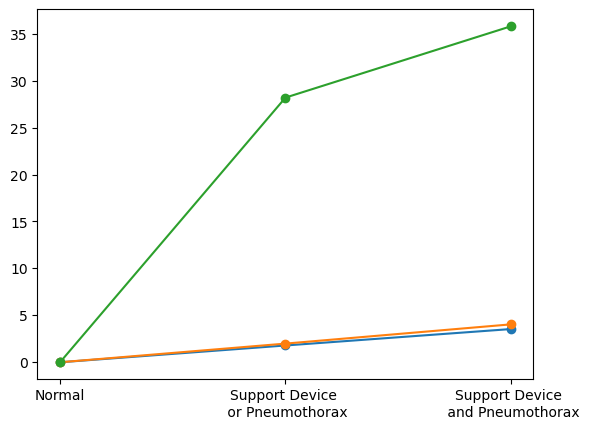

In [5]:
data = [
    {"labels": ["Normal", "Support Device \n or Pneumothorax", "Support Device \n and Pneumothorax"], 
     "heart": [0, 0.741, 3.54], 
     "lung": [0, 1.79, 3.54], 
     "title": "ImageNet-InceptionV3",
     "heart_label": "Support Device",
     "lung_label": "Pneumothorax"},

    {"labels": ["Normal", "Support Device \n or Pneumothorax", "Support Device \n and Pneumothorax"], 
     "heart": [0, 0.347, 4.04], 
     "lung": [0, 1.99, 4.04], 
     "title": "RadImageNet-InceptionV3",
     "heart_label": "Support Device",
     "lung_label": "Pneumothorax"},

    {"labels": ["Normal", "Support Device \n or Pneumothorax", "Support Device \n and Pneumothorax"], 
     "heart": [0, 3.55, 35.8], 
     "lung": [0, 28.2, 35.8], 
     "title": "NIH-InceptionV3",
     "heart_label": "Support Device",
     "lung_label": "Pneumothorax"}]

plt.plot(data[0]["labels"], data[0]["heart"], "-o", label=data[0]["heart_label"])
plt.plot(data[1]["labels"], data[1]["heart"], "-o", label=data[1]["heart_label"])
plt.plot(data[2]["labels"], data[2]["heart"], "-o", label=data[2]["heart_label"])
plt.figure()
plt.plot(data[0]["labels"], data[0]["lung"], "-o", label=data[0]["lung_label"])
plt.plot(data[1]["labels"], data[1]["lung"], "-o", label=data[1]["lung_label"])
plt.plot(data[2]["labels"], data[2]["lung"], "-o", label=data[2]["lung_label"])

## Summary of experiment 1 and 2

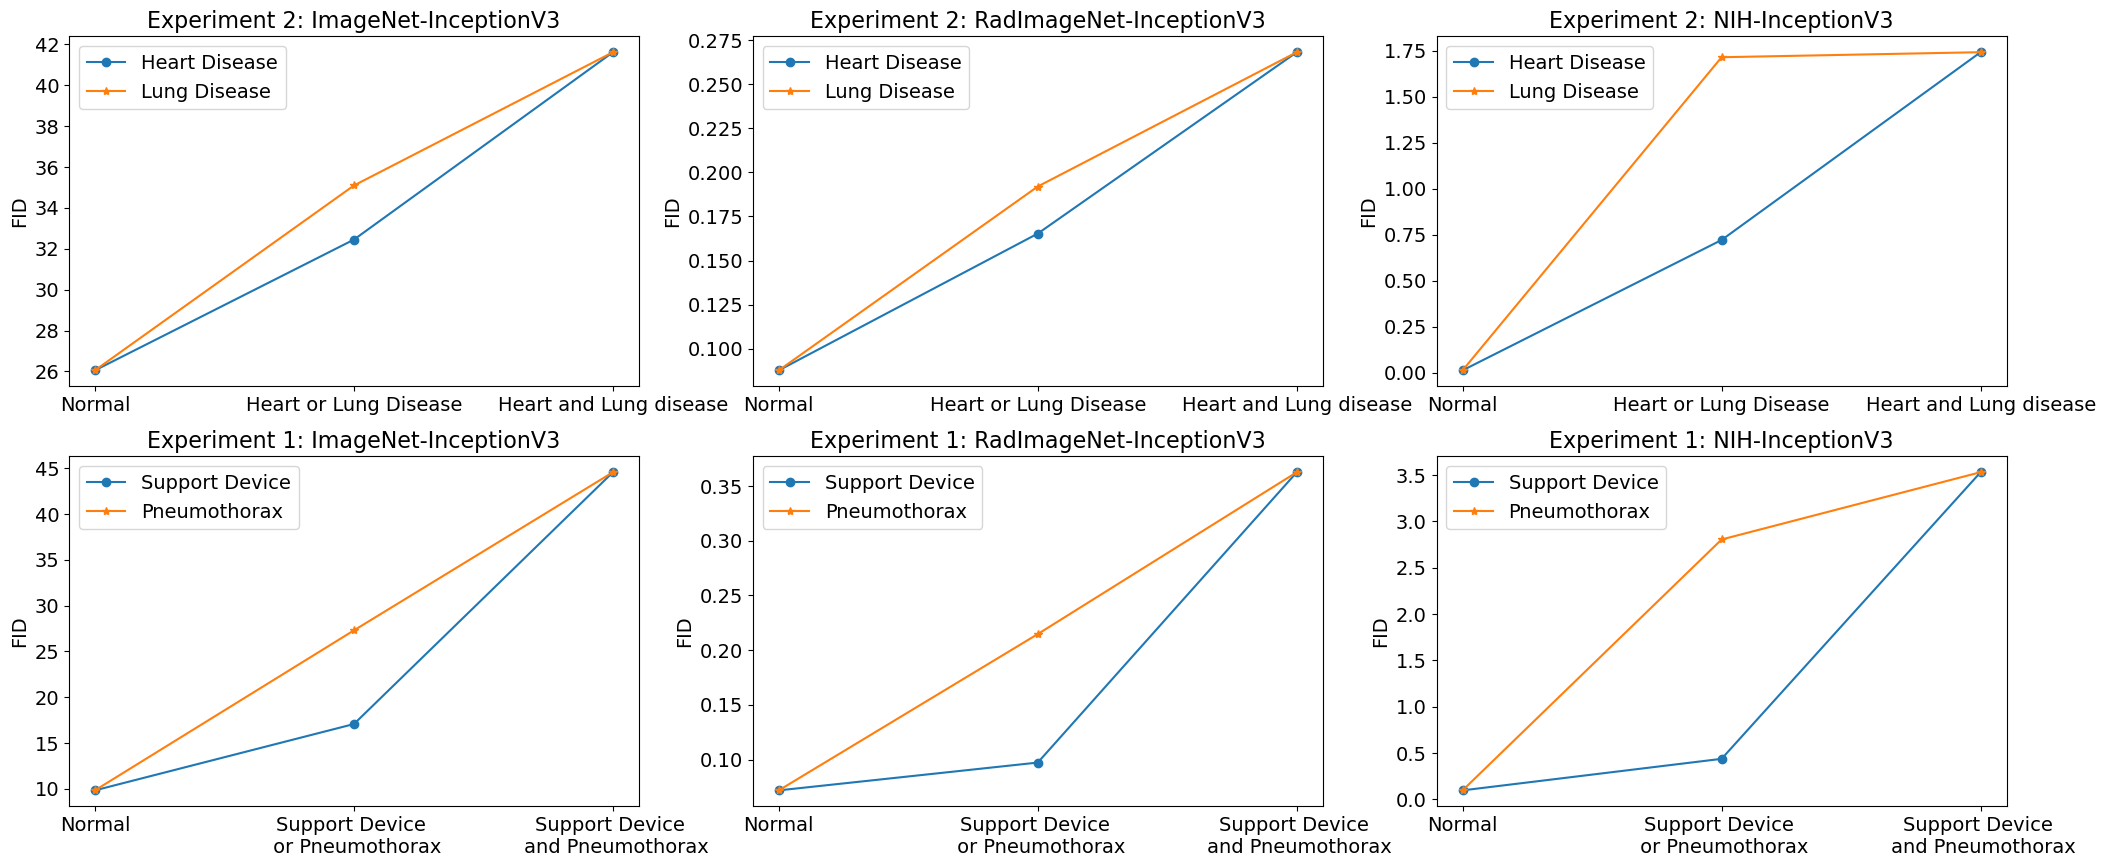

In [8]:
import matplotlib.pyplot as plt

data = [
    {"labels": ["Normal", "Heart or Lung Disease", "Heart and Lung disease"], 
     "heart": [26.0531, 32.4481, 41.6127], 
     "lung": [26.0531, 35.0943, 41.6127], 
     "title": "Experiment 2: ImageNet-InceptionV3",
     "heart_label": "Heart Disease",
     "lung_label": "Lung Disease"},

    {"labels": ["Normal", "Heart or Lung Disease", "Heart and Lung disease"], 
     "heart": [0.0877, 0.1653, 0.2682], 
     "lung": [0.0877, 0.1920, 0.2682], 
     "title": "Experiment 2: RadImageNet-InceptionV3",
     "heart_label": "Heart Disease",
     "lung_label": "Lung Disease"},
    
    {"labels": ["Normal", "Heart or Lung Disease", "Heart and Lung disease"], 
     "heart": [0.0138, 0.7220, 1.7421], 
     "lung": [0.0138, 1.7147, 1.7421], 
     "title": "Experiment 2: NIH-InceptionV3",
     "heart_label": "Heart Disease",
     "lung_label": "Lung Disease"},

    {"labels": ["Normal", "Support Device \n or Pneumothorax", "Support Device \n and Pneumothorax"], 
     "heart": [9.8245, 17.0689, 44.5733], 
     "lung": [9.8245, 27.2996, 44.5733], 
     "title": "Experiment 1: ImageNet-InceptionV3",
     "heart_label": "Support Device",
     "lung_label": "Pneumothorax"},

    {"labels": ["Normal", "Support Device \n or Pneumothorax", "Support Device \n and Pneumothorax"], 
     "heart": [0.0719, 0.0973, 0.3626], 
     "lung": [0.0719, 0.2147, 0.3626], 
     "title": "Experiment 1: RadImageNet-InceptionV3",
     "heart_label": "Support Device",
     "lung_label": "Pneumothorax"},

    {"labels": ["Normal", "Support Device \n or Pneumothorax", "Support Device \n and Pneumothorax"], 
     "heart": [0.0964, 0.4367, 3.5299], 
     "lung": [0.0964, 2.8036, 3.5299], 
     "title": "Experiment 1: NIH-InceptionV3",
     "heart_label": "Support Device",
     "lung_label": "Pneumothorax"}
]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(25, 10))
axes = axes.flatten()  # Flatten the 2D array to 1D for easy iteration
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# Plot each subplot
for i, ax in enumerate(axes):
    ax.plot(data[i]["labels"], data[i]["heart"], "-o", label=data[i]["heart_label"])
    ax.plot(data[i]["labels"], data[i]["lung"], "-*", label=data[i]["lung_label"])
    ax.set_title(data[i]["title"])
    ax.set_ylabel("FID")
    ax.legend()

# Adjust layout
#plt.tight_layout()

plt.show()


## Experiment 3 data visualization

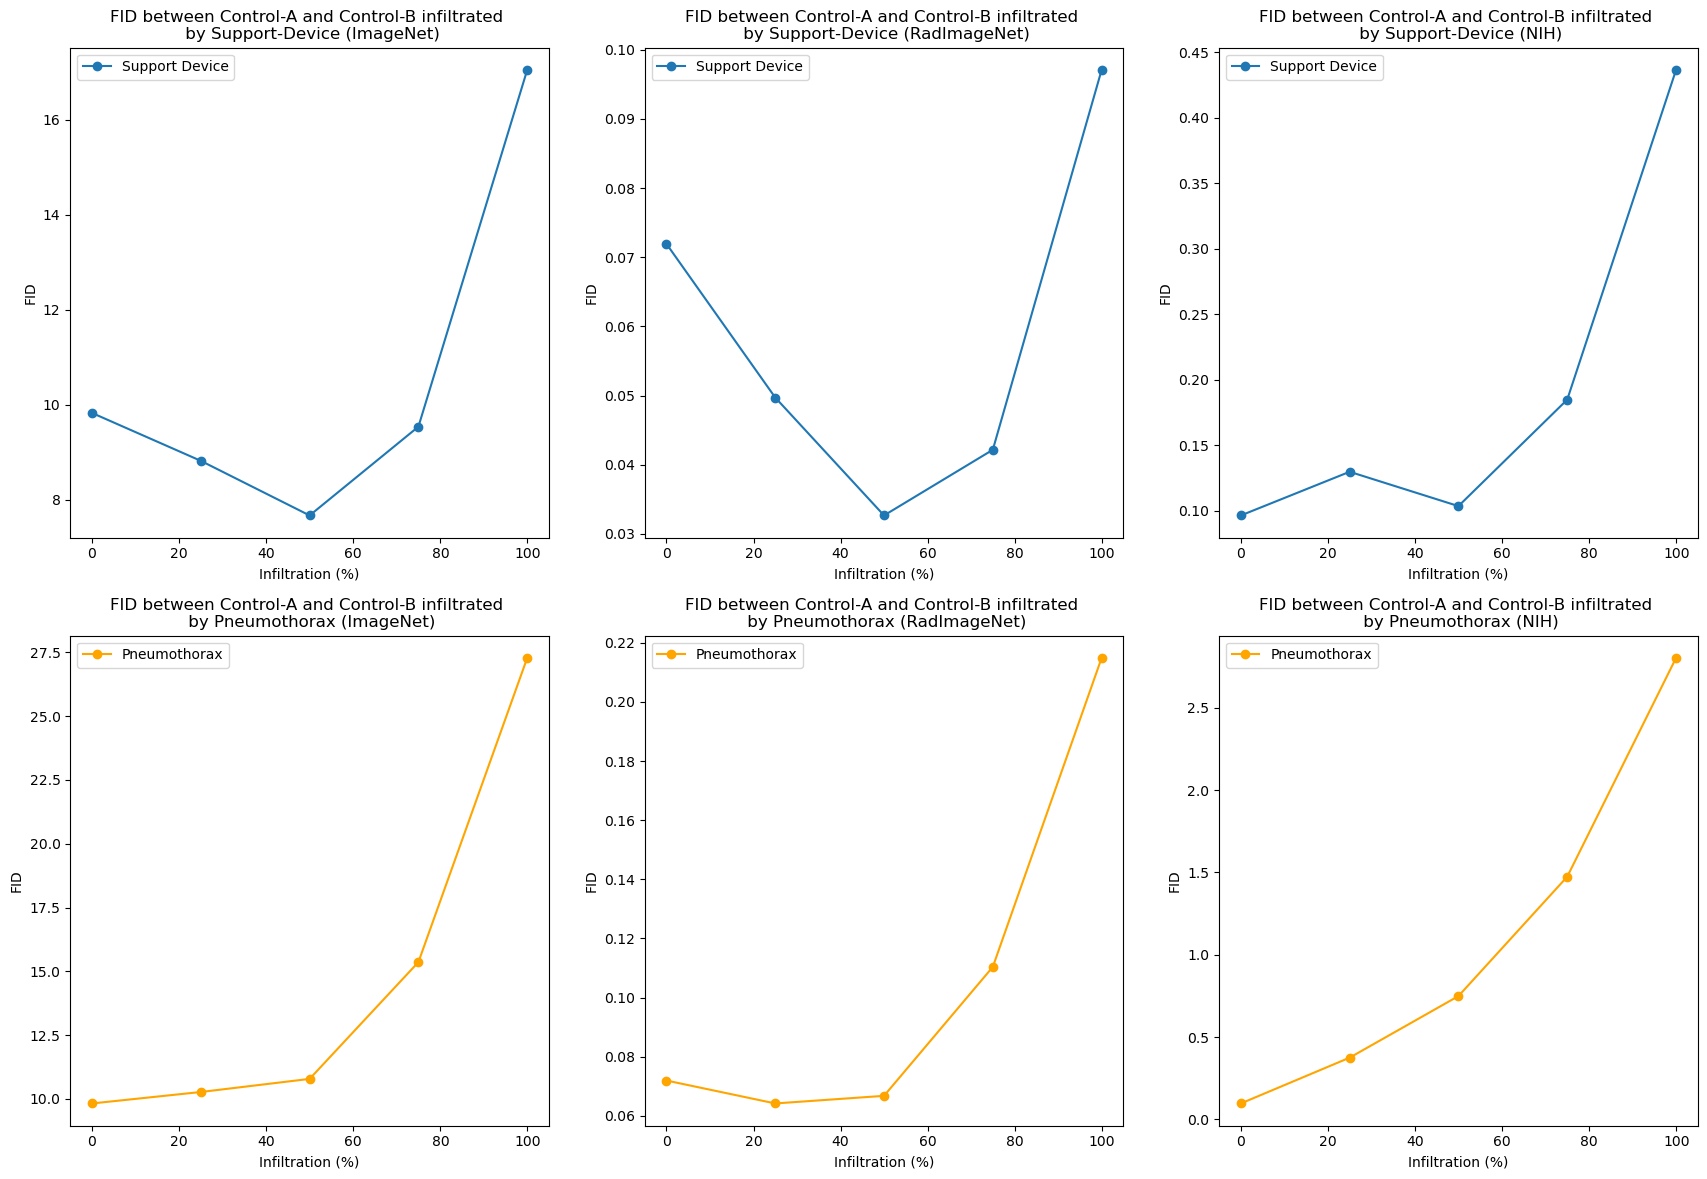

In [31]:
import matplotlib.pyplot as plt

# Data for the device (NIH model)
infiltration_device_nih = [0.0, 24.984293193717278, 49.968586387434556, 74.95287958115183, 99.93717277486911]
fid_device_nih = [0.09638746339845525, 0.12970762352411613, 0.10352012750408209, 0.18476056666484542, 0.436284257062908]

# Data for the lung (NIH model)
infiltration_lung_nih = [0.0, 24.984293193717278, 49.968586387434556, 74.95287958115183, 99.93717277486911]
fid_lung_nih = [0.09638746339843506, 0.3745639268808562, 0.7486260979920605, 1.4737917244223047, 2.8024204119642433]

# Data for the device (ImageNet model)
infiltration_device_imagenet = [0.0, 24.984293193717278, 49.968586387434556, 74.95287958115183, 99.93717277486911]
fid_device_imagenet = [9.824461039272993, 8.815629626952955, 7.665217264264454, 9.535554567726816, 17.050447868483495]

# Data for the lung (ImageNet model)
infiltration_lung_imagenet = [0.0, 24.984293193717278, 49.968586387434556, 74.95287958115183, 99.93717277486911]
fid_lung_imagenet = [9.824461039272993, 10.273199350957983, 10.78634932116061, 15.361862264149753, 27.27768177161714]

# Data for the device (RadImageNet model)
infiltration_device_radimagenet = [0.0, 24.984293193717278, 49.968586387434556, 74.95287958115183, 99.93717277486911]
fid_device_radimagenet = [0.07194012420794978, 0.0497218446010924, 0.03267425457487766, 0.042167695519417445, 0.09707441348297692]

# Data for the lung (RadImageNet model)
infiltration_lung_radimagenet = [0.0, 24.984293193717278, 49.968586387434556, 74.95287958115183, 99.93717277486911]
fid_lung_radimagenet = [0.07194012420794978, 0.06418626203895697, 0.06676023925249949, 0.11036535309119166, 0.21483648842707864]

fig, axes = plt.subplots(2, 3, figsize=(21, 14))
axes = axes.flatten() 

# Plot for NIH model (device)
axes[2].plot(infiltration_device_nih, fid_device_nih, '-o', label='Support Device')
axes[2].set_xlabel('Infiltration (%)')
axes[2].set_ylabel('FID')
axes[2].set_title('FID between Control-A and Control-B infiltrated \n by Support-Device (NIH)')
axes[2].legend()

# Plot for NIH model (lung)
axes[5].plot(infiltration_lung_nih, fid_lung_nih, '-o', label='Pneumothorax', color = "orange")
axes[5].set_xlabel('Infiltration (%)')
axes[5].set_ylabel('FID')
axes[5].set_title('FID between Control-A and Control-B infiltrated \n by Pneumothorax (NIH)')
axes[5].legend()

# Plot for ImageNet model (device)
axes[0].plot(infiltration_device_imagenet, fid_device_imagenet, '-o', label='Support Device')
axes[0].set_xlabel('Infiltration (%)')
axes[0].set_ylabel('FID')
axes[0].set_title('FID between Control-A and Control-B infiltrated \n by Support-Device (ImageNet)')
axes[0].legend()

# Plot for ImageNet model (lung)
axes[3].plot(infiltration_lung_imagenet, fid_lung_imagenet, '-o', label='Pneumothorax', color = "orange")
axes[3].set_xlabel('Infiltration (%)')
axes[3].set_ylabel('FID')
axes[3].set_title('FID between Control-A and Control-B infiltrated \n by Pneumothorax (ImageNet)')
axes[3].legend()

# Plot for RadImageNet model (device)
axes[1].plot(infiltration_device_radimagenet, fid_device_radimagenet, '-o', label='Support Device')
axes[1].set_xlabel('Infiltration (%)')
axes[1].set_ylabel('FID')
axes[1].set_title('FID between Control-A and Control-B infiltrated \n by Support-Device (RadImageNet)')
axes[1].legend()

# Plot for RadImageNet model (lung)
axes[4].plot(infiltration_lung_radimagenet, fid_lung_radimagenet, '-o', label='Pneumothorax', color = "orange")
axes[4].set_xlabel('Infiltration (%)')
axes[4].set_ylabel('FID')
axes[4].set_title('FID between Control-A and Control-B infiltrated \n by Pneumothorax (RadImageNet)')
axes[4].legend()

#plt.tight_layout()

plt.show()


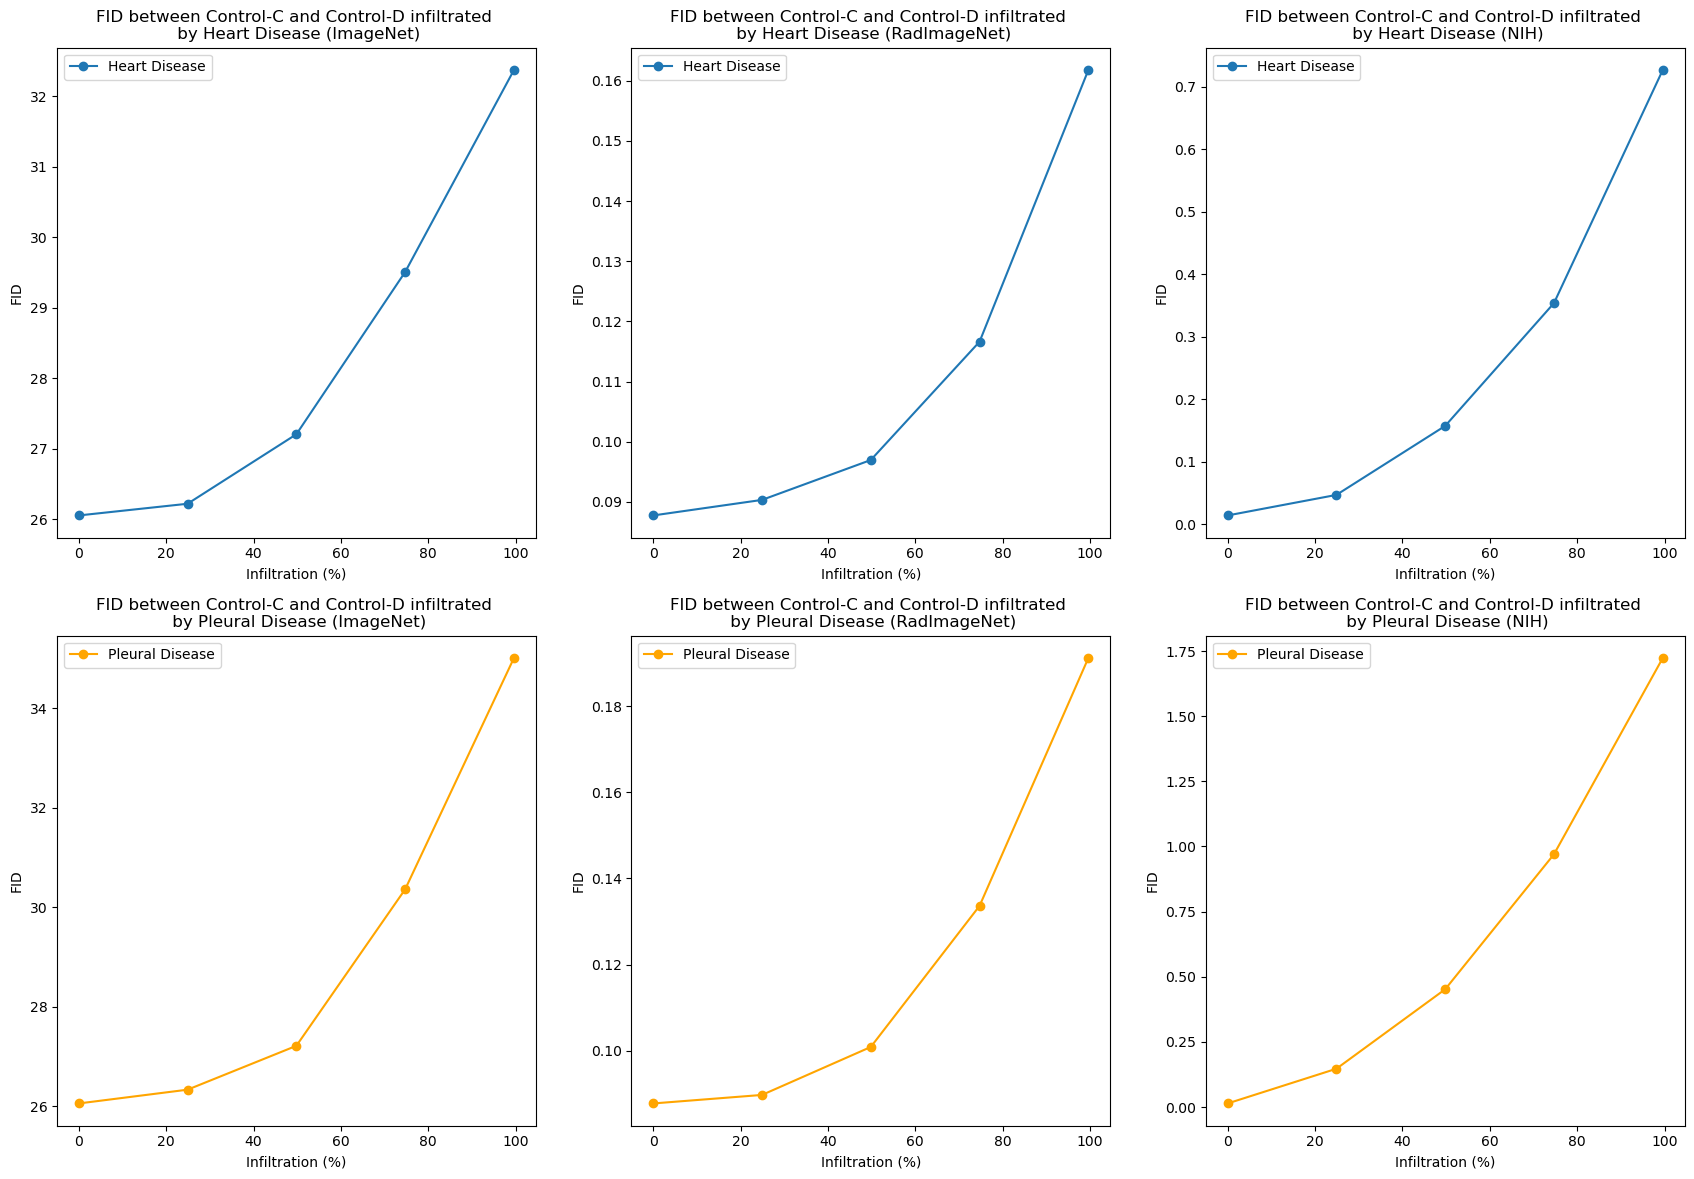

In [34]:
import matplotlib.pyplot as plt

# Data for NIH model
infiltration_nih = [0.0, 24.900133155792275, 49.80026631158455, 74.70039946737683, 99.6005326231691]
fid_heart_nih = [0.013837214119421876, 0.04672064601474392, 0.1571635042154707, 0.3537565276412186, 0.7268795733190835]
fid_lung_nih = [0.013837214120280297, 0.14698315069451445, 0.45202750916091516, 0.9701852494136772, 1.723290836708892]

# Data for ImageNet model
infiltration_imagenet = [0.0, 24.900133155792275, 49.80026631158455, 74.70039946737683, 99.6005326231691]
fid_heart_imagenet = [26.05308393662736, 26.218972863587254, 27.204083987915418, 29.505668475669708, 32.369794374673305]
fid_lung_imagenet = [26.05308393662736, 26.329901422935077, 27.211676202299735, 30.3583910387929, 35.00881295737856]

# Data for RadImageNet model
infiltration_radimagenet = [0.0, 24.900133155792275, 49.80026631158455, 74.70039946737683, 99.6005326231691]
fid_heart_radimagenet = [0.08773492185144849, 0.09031878568257815, 0.09694794144768136, 0.11662169515598377, 0.16179260215109348]
fid_lung_radimagenet = [0.08773492185144849, 0.08971261963097109, 0.10084977318884976, 0.1336202368576849, 0.1911777532219931]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(21, 14))
axes = axes.flatten()  # Flatten the 2D array to 1D for easy iteration

# Plot for NIH model (heart)
axes[2].plot(infiltration_nih, fid_heart_nih, '-o', label='Heart Disease')
axes[2].set_xlabel('Infiltration (%)')
axes[2].set_ylabel('FID')
axes[2].set_title('FID between Control-C and Control-D infiltrated \n by Heart Disease (NIH)')
axes[2].legend()

# Plot for NIH model (lung)
axes[5].plot(infiltration_nih, fid_lung_nih, '-o', label='Pleural Disease', color = "orange")
axes[5].set_xlabel('Infiltration (%)')
axes[5].set_ylabel('FID')
axes[5].set_title('FID between Control-C and Control-D infiltrated \n by Pleural Disease (NIH)')
axes[5].legend()

# Plot for ImageNet model (heart)
axes[0].plot(infiltration_imagenet, fid_heart_imagenet, '-o', label='Heart Disease')
axes[0].set_xlabel('Infiltration (%)')
axes[0].set_ylabel('FID')
axes[0].set_title('FID between Control-C and Control-D infiltrated \n by Heart Disease (ImageNet)')
axes[0].legend()

# Plot for ImageNet model (lung)
axes[3].plot(infiltration_imagenet, fid_lung_imagenet, '-o', label='Pleural Disease', color = "orange")
axes[3].set_xlabel('Infiltration (%)')
axes[3].set_ylabel('FID')
axes[3].set_title('FID between Control-C and Control-D infiltrated \n by Pleural Disease (ImageNet)')
axes[3].legend()

# Plot for RadImageNet model (heart)
axes[1].plot(infiltration_radimagenet, fid_heart_radimagenet, '-o', label='Heart Disease')
axes[1].set_xlabel('Infiltration (%)')
axes[1].set_ylabel('FID')
axes[1].set_title('FID between Control-C and Control-D infiltrated \n by Heart Disease (RadImageNet)')
axes[1].legend()

# Plot for RadImageNet model (lung)
axes[4].plot(infiltration_radimagenet, fid_lung_radimagenet, '-o', label='Pleural Disease', color = "orange")
axes[4].set_xlabel('Infiltration (%)')
axes[4].set_ylabel('FID')
axes[4].set_title('FID between Control-C and Control-D infiltrated \n by Pleural Disease (RadImageNet)')
axes[4].legend()

# Adjust layout to prevent overlap
#plt.tight_layout()
plt.show()


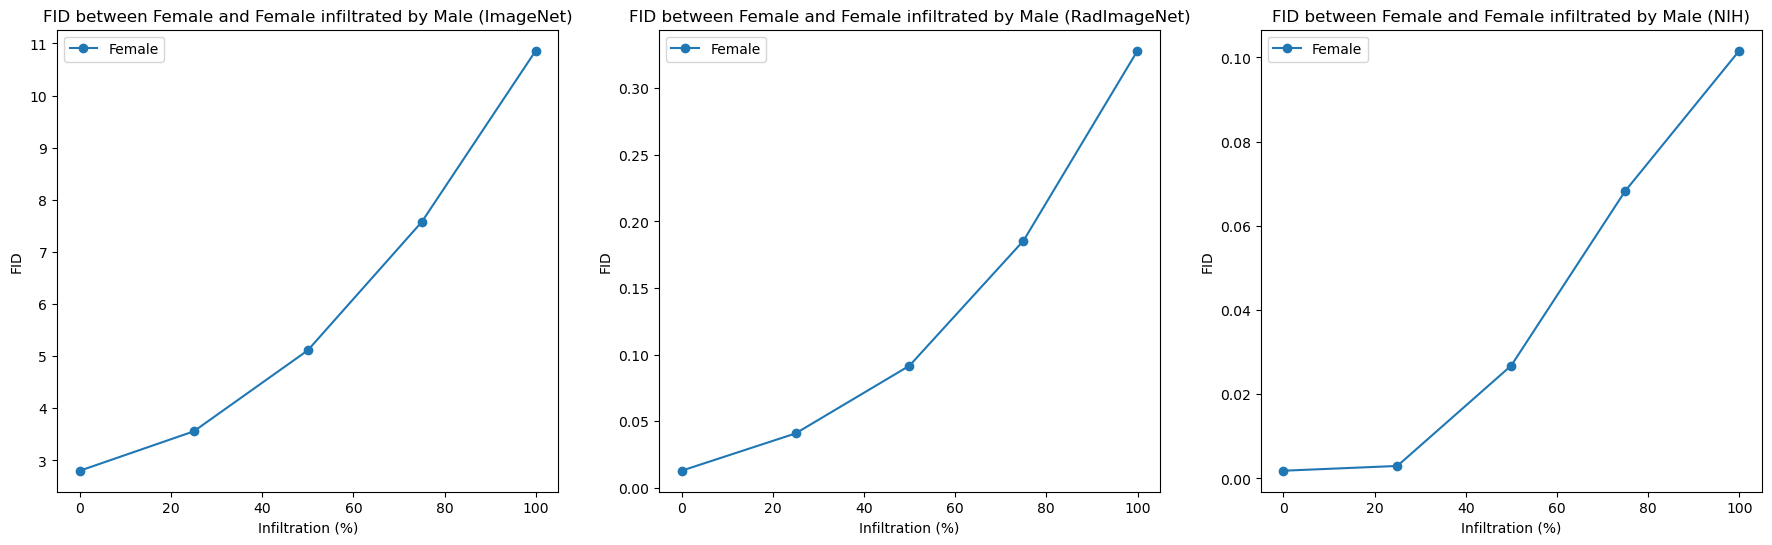

In [41]:
import matplotlib.pyplot as plt

# Data for NIH model
infiltration_nih = [0.0, 24.99400133155792275, 49.980026631158455, 74.980039946737683, 99.98]
fid_female_nih = [0.0018442909096051088, 0.0029776299269766273, 0.02681501065611354, 0.06828930913718177, 0.10159841810267839]

# Data for ImageNet model
infiltration_imagenet = [0.0, 24.99400133155792275, 49.980026631158455, 74.980039946737683, 99.98]
fid_female_imagenet = [2.8038072024593133, 3.559375110807935, 5.11157266991375, 7.574347435995617, 10.859949894849276]

# Data for RadImageNet model
infiltration_radimagenet = [0.0, 24.99400133155792275, 49.980026631158455, 74.980039946737683, 99.98]
fid_female_radimagenet = [0.012961893078183157, 0.04094130511927431, 0.09175912449603255, 0.1855156301709917, 0.3280768432752758]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
axes = axes.flatten()  # Flatten the 2D array to 1D for easy iteration

# Plot for NIH model (female)
axes[2].plot(infiltration_nih, fid_female_nih, '-o', label='Female')
axes[2].set_xlabel('Infiltration (%)')
axes[2].set_ylabel('FID')
axes[2].set_title('FID between Female and Female infiltrated by Male (NIH)')
axes[2].legend()


# Plot for ImageNet model (female)
axes[0].plot(infiltration_imagenet, fid_female_imagenet, '-o', label='Female')
axes[0].set_xlabel('Infiltration (%)')
axes[0].set_ylabel('FID')
axes[0].set_title('FID between Female and Female infiltrated by Male (ImageNet)')
axes[0].legend()


# Plot for RadImageNet model (female)
axes[1].plot(infiltration_radimagenet, fid_female_radimagenet, '-o', label='Female')
axes[1].set_xlabel('Infiltration (%)')
axes[1].set_ylabel('FID')
axes[1].set_title('FID between Female and Female infiltrated by Male (RadImageNet)')
axes[1].legend()


# Adjust layout to prevent overlap
#plt.tight_layout()
plt.show()

## Features

In [43]:
import json
import numpy as np
# Load the lists from the file
with open('female_male_features_no_top_best_3_chex_0001_random_wd_005_b_64.h5.json', 'r') as file:
    data = json.load(file)
    fem_list = np.array(data['female_features'])
    male_list = np.array(data['male_features'])


mu1, sigma1 = np.mean(fem_list, axis=0), np.cov(fem_list, rowvar=False)
mu2, sigma2 = np.mean(male_list, axis=0), np.cov(male_list, rowvar=False)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


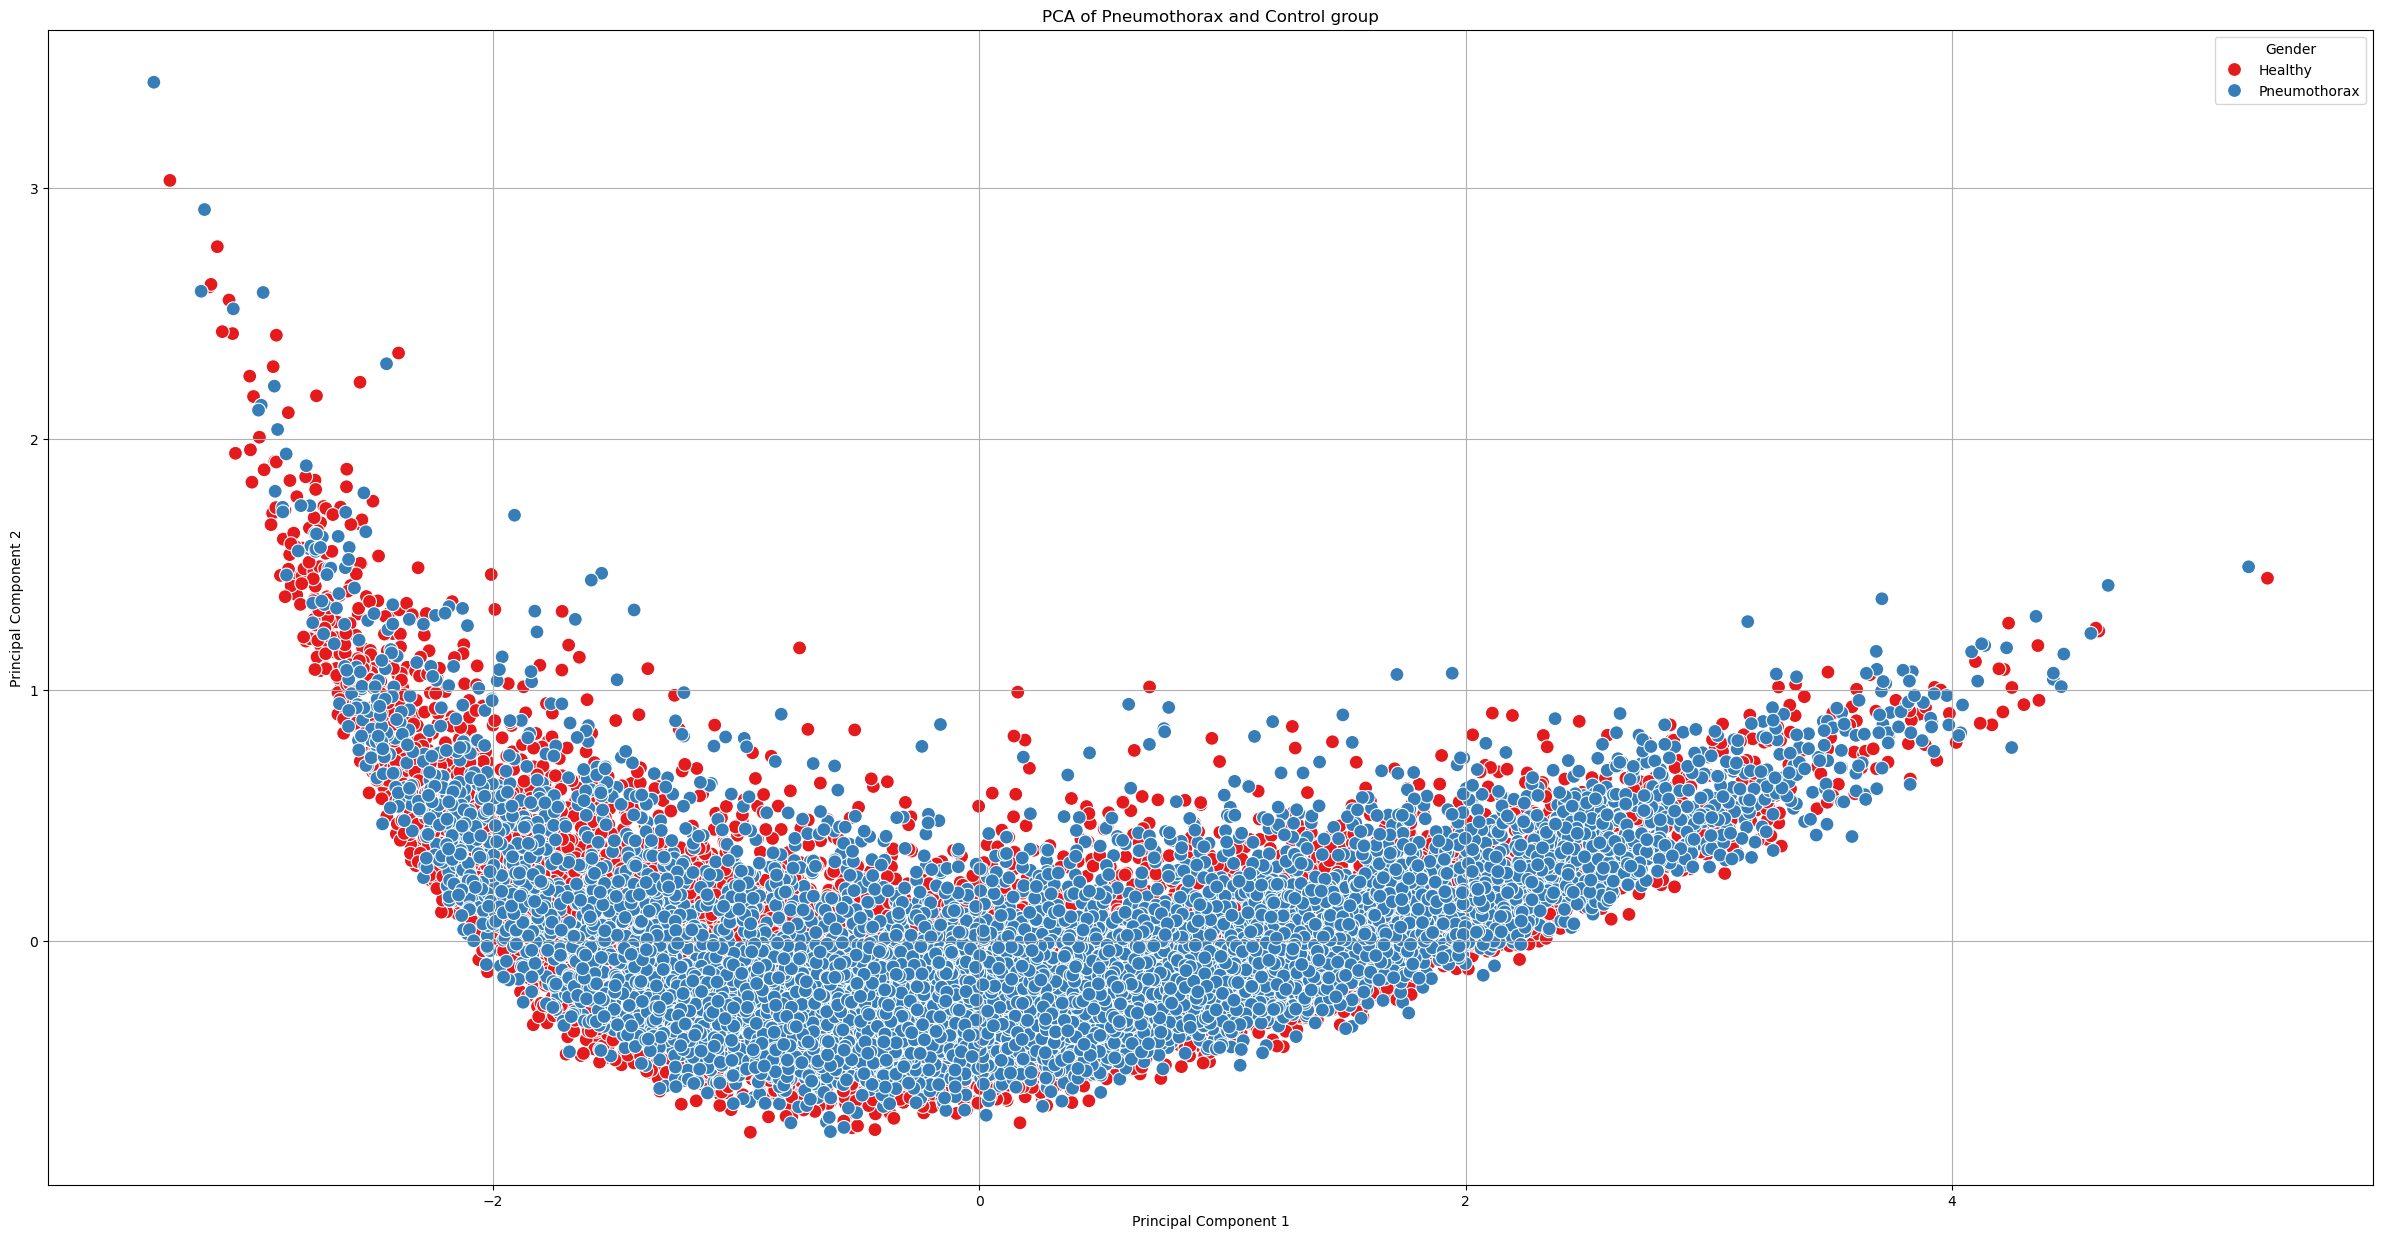

In [6]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
columns = [f'Column{i+1}' for i in range(2048)]
# Convert numpy matrices to pandas DataFrames
fem_df = pd.DataFrame(fem_list, columns=columns)
male_df = pd.DataFrame(male_list, columns=columns)

# Add a new column to differentiate between fem_list and male_list
fem_df['Gender'] = 'Healthy'
male_df['Gender'] = 'Pneumothorax'

# Combine the two DataFrames
df = pd.concat([fem_df, male_df], ignore_index=True)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df.drop(columns=['Gender']))

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])
pca_df['Gender'] = df['Gender']

# Calculate total explained variance
total_var = pca.explained_variance_ratio_.sum() * 100
print("Total Variance Explained by PCA: {:.2f}%".format(total_var))

# Plotting
plt.figure(figsize=(30, 15))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Gender', palette='Set1', s=100)
plt.title('PCA of Pneumothorax and Control group')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Gender')
plt.grid(True)
plt.show()



In [1]:
import json
import numpy as np
# Load the lists from the file
with open('female_male_features_RadImageNet-InceptionV3_notop.h5.json', 'r') as file:
    data = json.load(file)
    fem_list = np.array(data['female_features'])
    male_list = np.array(data['male_features'])



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [39]:
# Function to calculate Frechét distance
def calculate_fid(feat1, feat2):
    '''
    calculate fid between two sets of images
    return: fid score
    '''
    # calculate mean and covariance of features
    mu1, sigma1 = np.mean(feat1, axis=0), np.cov(feat1, rowvar=False) 
    mu2, sigma2 = np.mean(feat2, axis=0), np.cov(feat2, rowvar=False)
    # sum squared difference between means
    diff = np.sum((mu1 - mu2)**2)
 
    # calculate "geometric mean" of covariance matrices
    covmean = fractional_matrix_power(sigma1.dot(sigma2), 0.5)
    # check for imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = np.real(covmean)

    fid = diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [3]:
# ImageNet
calculate_fid(fem_list[:751],male_list[:751])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


36.873111341393496

In [4]:
#ImageNet
calculate_fid(fem_list[:4775],male_list[:4775])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


13.840933046288315

In [3]:
# NIH
calculate_fid(fem_list[:751],male_list[:751])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.10705498785306058

In [5]:
# NIH
calculate_fid(fem_list[:4775],male_list[:4775])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.12013639655641636

In [3]:
# RadImageNet
calculate_fid(fem_list[:751],male_list[:751])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.39666790941318664

In [4]:
# RadImageNet
calculate_fid(fem_list[:4775],male_list[:4775])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.33837050447064754

In [9]:
calculate_fid(fem_list[:4775],fem_list[4775:2*4775])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.021392542187036005

## Cats vs Dogs

In [36]:
import json
import numpy as np
# Load the lists from the file
with open('features_pet.json', 'r') as file:
    data = json.load(file)



In [40]:
calculate_fid(data[:751],data[1000:1751])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


209.62059231196355

## Scales of features

In [1]:
import json
import numpy as np
# Load the lists from the file
with open('female_male_features_imagenet.json', 'r') as file:
    data = json.load(file)
    fem_list = np.array(data['female_features'])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


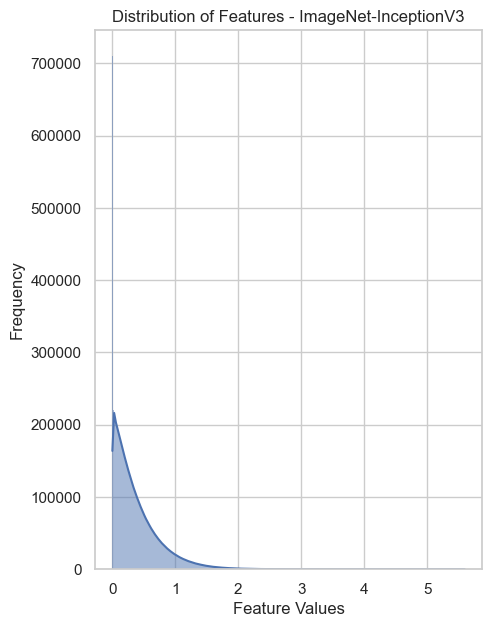

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
def plot_distribution(features, title):
    # Create subplots
    fig, ax = plt.subplots(figsize=(5, 7))
    
    # Plot distribution
    sns.histplot(features, kde=True, ax=ax)
    
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Feature Values')
    ax.set_ylabel('Frequency')

# Plot distribution for predictions
plot_distribution(fem_list.flatten(), 'Distribution of Features - ImageNet-InceptionV3')

plt.show()

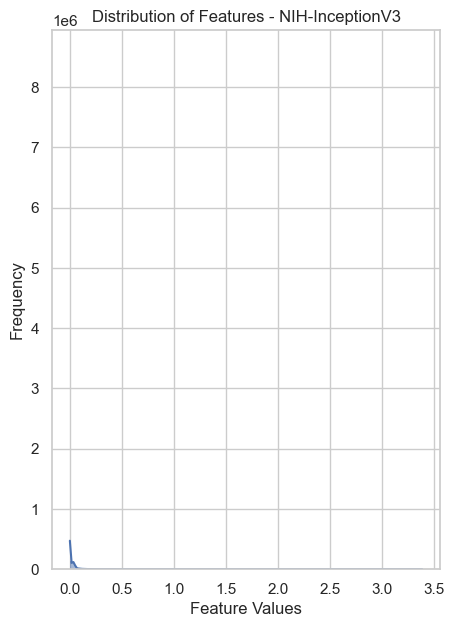

In [3]:
import json
import numpy as np
# Load the lists from the file
with open('female_male_features_no_top_best_3_chex_0001_random_wd_005_b_64.h5.json', 'r') as file:
    data = json.load(file)
    fem_list = np.array(data['female_features'])
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
def plot_distribution(features, title):
    # Create subplots
    fig, ax = plt.subplots(figsize=(5, 7))
    
    # Plot distribution
    sns.histplot(features, kde=True, ax=ax)
    
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Feature Values')
    ax.set_ylabel('Frequency')

# Plot distribution for predictions
plot_distribution(fem_list.flatten(), 'Distribution of Features - NIH-InceptionV3')

plt.show()

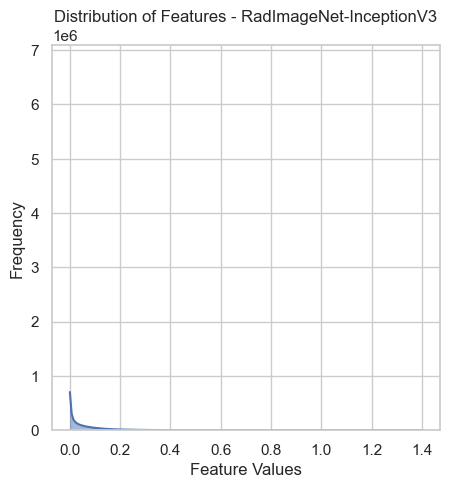

In [4]:
import json
import numpy as np
# Load the lists from the file
with open('female_male_features_RadImageNet-InceptionV3_notop.h5.json', 'r') as file:
    data = json.load(file)
    fem_list = np.array(data['female_features'])
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
def plot_distribution(features, title):
    # Create subplots
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Plot distribution
    sns.histplot(features, kde=True, ax=ax)
    
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Feature Values')
    ax.set_ylabel('Frequency')

# Plot distribution for predictions
plot_distribution(fem_list.flatten(), 'Distribution of Features - RadImageNet-InceptionV3')

plt.show()